## Nested groups and discrimination in a dynamic process
### have 2 large groups and 4 subgroups 
   - two systems of higher-lower
   - larger vs smaller groups

### ingroup nepotism so give more

### inclination to any identity depends on the social statues (in prev papers)
   - dep on aggreagte wealth
   - the more the higher
    
### policy intervention
   - helpin whatever the better performing
   - helping idiosyncratically

In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
import random
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
def gen_type_lst(num_agent):
    r = num_agent % 4
    num_no_res = num_agent - r
    num_avg = int(num_no_res / 4)
    lst_types = []
    types = [1,2,3,4]
    #for equal group sizes
    #for i in range(1,5):
        #lst_i = [i][:]*num_avg
        #lst_types += lst_i
    
    for i in [1,2]:
        if i == 1:
            num_small = round(num_avg*random.uniform(0.5,0.8))
            lst_i = [i][:]*num_small
            lst_types += lst_i

            num_3 = num_avg * 2 - num_small
            lst_3 = [3][:]*num_3
            lst_types += lst_3
        elif i == 2:
            num_small = round(num_avg*random.uniform(0,0.2))
            lst_i = [i][:]*num_small
            lst_types += lst_i
            
            num_4 = num_avg * 2 - num_small
            lst_4 = [4][:]*num_4
            lst_types += lst_4
             
    for _ in range(r):
        i = random.choice(types)
        lst_types.append(i)
        types.remove(i)
    return lst_types
            
class Agent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 0
        r = random.choice(self.model.index)
        rand = self.model.lst_types[r]
        self.type = rand
        self.init_type = rand
        self.model.index.remove(r)
        self.met = [self.unique_id]  
            
    def step(self):
        self.set_type()
        while len(self.met) != len(self.model.schedule.agents):
            other_agent = self.random.choice(self.model.schedule.agents)
            if other_agent.unique_id not in self.met:
                empha = self.empha_lower()
                propo = self.gen_propo(other_agent, empha)
                propo = self.propo_res(propo)
                giving = round(propo * 10)
                other_agent.wealth += giving
                self.wealth += (10 - giving)
                self.met.append(other_agent.unique_id)
                self.model.giving_df.loc[len(self.model.giving_df.index)] = [self.init_type, self.type, other_agent.init_type,empha,giving,propo]
                
    def set_type(self):
        typ = self.type
        if typ in [1,3]:
            h_type = [1,3]
        else:
            h_type = [2,4]
        wealth_l = 0
        num_l = 0
        wealth_h = 0
        num_h = 0
        for a in self.model.schedule.agents:
            if a.type == typ:
                wealth_l += a.wealth
                wealth_h += a.wealth
                num_l += 1
                num_h += 1
            elif a.type in h_type:
                wealth_h += a.wealth
                num_h += 1
        avg_l = wealth_l / num_l
        avg_h = wealth_h / num_h
        
        if avg_l < avg_h:    #equal is considered in as emphasizing lower based on data and results
            self.type = h_type
              
    def empha_lower(self):
        if type(self.type) == int:
            empha = True
        else:
            empha = False
        return empha
            
    
    def gen_propo(self,other,empha_lower):
        propo = random.uniform(0,0.3)
        rand = random.uniform(0,1)
        if rand >= 0.6:     #assuming 30% ppl discriminate; will dep on data as input
            if type(other.type) == int:
                if empha_lower == True:
                    if self.type % 2 == other.type % 2:
                        propo += random.uniform(0,0.3)
                        if self.type == other.type:
                            propo += random.uniform(0,0.3)
                else:
                    if other.type in self.type:
                        propo += random.uniform(0,0.3)
            else:
                if other.type == self.type:
                    propo += random.uniform(0,0.3)
        else:
            propo = random.uniform(0,1)

        return propo
    
    def propo_res(self,propo):
        rand = random.uniform(0,1)
        if rand <= 0.75:    #will input based on lit
            actual_propo = propo * 0.5
        else:
            actual_propo = propo
            
        return actual_propo 

class Model(Model):
    """A model with some number of agents."""
    def __init__(self, N, seed = None):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.running = True
        self.giving_df = pd.DataFrame(columns=['init_type','type','other type','empha','giving','propo'])
        self.lst_types = gen_type_lst(N)
        self.index = list(range(N))
        # Create agents
        for i in range(self.num_agents):
            a = Agent(i, self)
            self.schedule.add(a)    #seems like a list of all agents

    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()

In [87]:
gen_type_lst(16)

[1, 1, 1, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4]

In [4]:
m = Model(16)

IndexError: list index out of range

In [4]:
[i.wealth for i in m.schedule.agents]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### ?why i have to restart kernel multiple times to run it repeatedly?

In [3]:
df = []
for _ in range(100):
    m = Model(16)
    m.step()
    df.append(m.giving_df)
dff=pd.concat(df)

In [18]:
dff['type']

0      4
1      4
2      4
3      4
4      4
      ..
235    3
236    3
237    3
238    3
239    3
Name: type, Length: 24000, dtype: object

In [7]:
g_out = []
g_h_in = []
g_l_in = []
empha = []
for r in dff.iterrows():
    if r[1][0] == r[1][2]:
        g_l_in.append(r[1][4])
    elif r[1][0]%2 == r[1][2]%2:
        g_h_in.append(r[1][4])
    else:
        g_out.append(r[1][4])
    empha.append(r[1][3])

In [5]:
import matplotlib.pyplot as plt

#### with disc percent = 30%

(array([1079., 2157., 2245., 1497.,  863.,  923.,  864.,  906.,  910.,
        1356.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

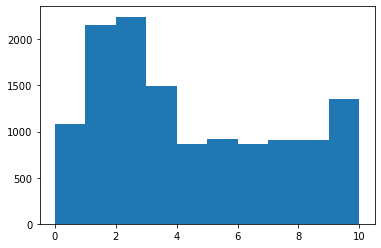

In [7]:
plt.hist(g_out) 

(array([305., 768., 913., 984., 757., 622., 449., 460., 454., 688.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

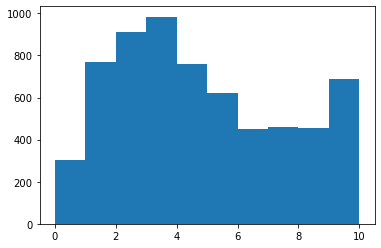

In [8]:
plt.hist(g_h_in)

(array([170., 450., 577., 673., 683., 585., 415., 393., 329., 525.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

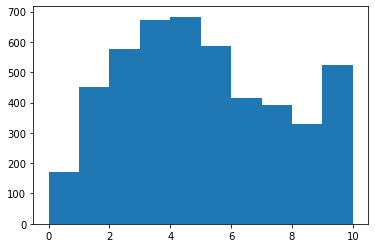

In [9]:
plt.hist(g_l_in)

#### with disc percent = 40%

(array([1179., 2444., 2459., 1656.,  784.,  773.,  763.,  824.,  729.,
        1189.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

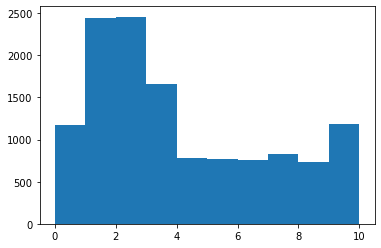

In [8]:
plt.hist(g_out) 

(array([ 290.,  774., 1044., 1093.,  821.,  631.,  418.,  390.,  369.,
         570.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

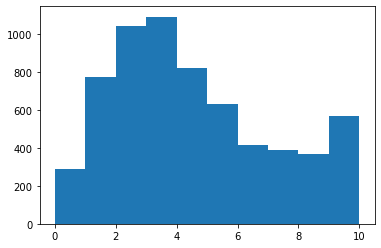

In [9]:
plt.hist(g_h_in)

(array([135., 417., 614., 775., 743., 619., 418., 364., 278., 437.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

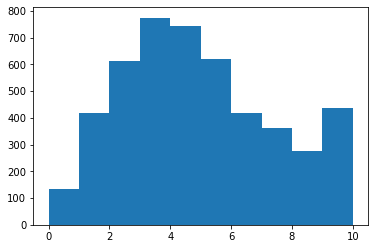

In [10]:
plt.hist(g_l_in)

#### 40% disc with restriction that in most cases send less than 50%

(array([2211., 4343., 1731., 1540., 1362.,  744.,  205.,  196.,  182.,
         286.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

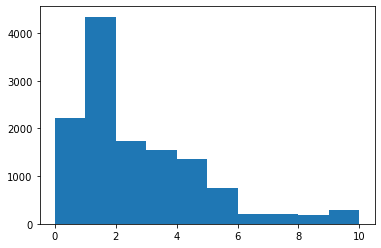

In [8]:
plt.hist(g_out) 

(array([ 592., 1627., 1563.,  920.,  833.,  423.,   86.,  111.,   97.,
         148.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

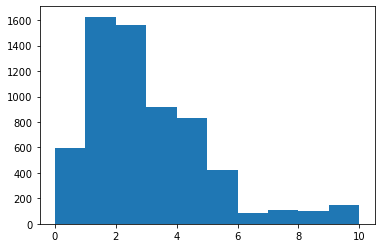

In [9]:
plt.hist(g_h_in)

(array([ 312.,  958., 1262.,  899.,  636.,  364.,  112.,   74.,   66.,
         117.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

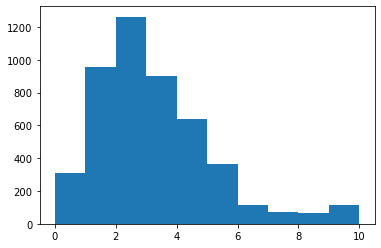

In [10]:
plt.hist(g_l_in)

#### 40% with restriction with unequal group sizes

(array([2208., 4274., 1756., 1542., 1367.,  757.,  199.,  185.,  223.,
         289.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

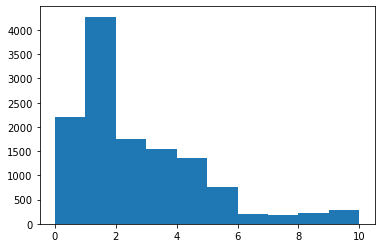

In [8]:
plt.hist(g_out) 

(array([305., 856., 751., 472., 405., 220.,  45.,  50.,  42.,  84.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

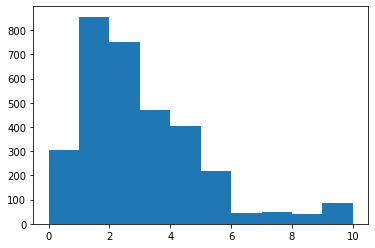

In [9]:
plt.hist(g_h_in)

(array([ 461., 1371., 2013., 1688., 1127.,  616.,  213.,  162.,  129.,
         190.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

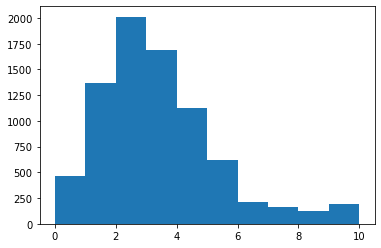

In [10]:
plt.hist(g_l_in)

(array([ 3780.,     0.,     0.,   555.,     0.,     0.,  8220.,     0.,
            0., 11445.]),
 array([1.0, 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.6999999999999997,
        4.0], dtype=object),
 <BarContainer object of 10 artists>)

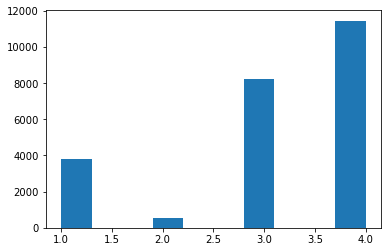

In [16]:
plt.hist(dff['init_type'])

(array([480.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  75.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

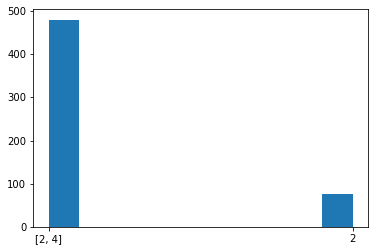

In [28]:
l = [str(i) for i in list(dff[dff['init_type']==2]['type'])]
plt.hist(l)

(array([10800.,     0.,  5400.,     0.,  1305.,     0.,  1125.,     0.,
         5295.,    75.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

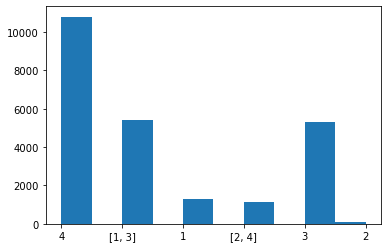

In [27]:
l = [str(i) for i in list(dff['type'])]
plt.hist(l)

#### privilege and minority: feminist case

In [ ]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
import random
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

In [2]:
def gen_type_lst(num_agent):
    r = num_agent % 4
    num_no_res = num_agent - r
    num_avg = int(num_no_res / 4)
    lst_types = []
    types = ['ff','nf','fm','nm'] #feminist female, non-feminist female, feminist male, non-feminist male

    num_ff = round(num_avg*random.uniform(0,0.6)) #feminist female
    if num_ff <= 1:
        num_ff = 1
    lst_ff = ['ff'][:]*num_ff
    lst_types += lst_ff

    num_nf = num_avg * 2 - num_ff
    lst_nf = ['nf'][:]*num_nf
    lst_types += lst_nf

    num_fm = round(num_avg*random.uniform(0,0.4)) #feminist male
    if num_fm <= 1:
        num_fm = 1
    lst_fm = ['fm'][:]*num_fm
    lst_types += lst_fm
    
    num_nm = num_avg * 2 - num_fm
    lst_nm = ['nm'][:]*num_nm
    lst_types += lst_nm

    for _ in range(r):
        i = random.choice(types)
        lst_types.append(i)
        types.remove(i)

    return lst_types

class Agent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        r = random.choice(self.model.index)
        rand = self.model.lst_types[r]
        self.type = rand
        self.init_type = rand
        if self.unique_id not in self.model.giving_df['id']:
            if self.init_type == 'ff':
                self.wealth = 10
            else:
                self.wealth = 0
        else:
            df = self.model.giving_df
            self.wealth = list(df['wealth'][df['id'] == self.unique_id])[-1]
        self.model.index.remove(r)
        self.met = [self.unique_id] 
        self.group_wealth_l = 0
        self.group_wealth_h = 0
            
    def step(self):
        if len(self.model.giving_df) > 9 and list(self.model.giving_df['id'])[-1] != self.unique_id:
            self.met = [self.unique_id] 
        self.set_type()
        while len(self.met) != len(self.model.schedule.agents):
            other_agent = self.random.choice(self.model.schedule.agents)
            if other_agent.unique_id not in self.met:
                propo = self.gen_propo(other_agent)
                propo = self.propo_res(propo)
                giving = round(propo * 10)
                other_agent.wealth += giving
                self.wealth += (10 - giving)
                self.met.append(other_agent.unique_id)
                self.model.giving_df.loc[len(self.model.giving_df.index)] = [self.model.round, int(self.unique_id), int(self.wealth), self.group_wealth_l, self.group_wealth_h, self.init_type, self.type, other_agent.init_type,giving,propo]
                
    def set_type(self):
        typ = self.type
        if typ in ['ff','nf']:
            h_type = 'f'
        else:
            h_type = 'm'
        wealth_l = 0
        num_l = 0
        wealth_h = 0
        num_h = 0
        for a in self.model.schedule.agents:
            if a.type == typ:
                wealth_l += a.wealth
                wealth_h += a.wealth
                num_l += 1
                num_h += 1
            elif a.type.endswith(typ[-1]):
                wealth_h += a.wealth
                num_h += 1
        avg_l = wealth_l / num_l
        avg_h = wealth_h / num_h
        self.group_wealth_l = avg_l
        self.group_wealth_h = avg_h
        
        if avg_l < avg_h:    #equal is considered in as emphasizing lower based on data and results
            self.type = h_type
    
    def gen_propo(self,other):
        propo = random.uniform(0,0.3) # needs literature
        rand = random.uniform(0,1)
        if rand >= 0.6:     #assuming 40% ppl discriminate; will dep on data as input
            if len(self.type) == len(other.type):
                if len(self.type) == 1:
                    if self.type == other.type:
                        propo += random.uniform(0,0.3)
                    else:
                        if other.type == 'm':
                            propo += random.uniform(0,0.4) #patriarchy
                        else:
                            propo -= random.uniform(0,0.3) #misogyny    
                else:
                    if self.type == 'ff':
                        if other.type in ['ff','fm']:
                            propo += random.uniform(0,0.3)
                            propo += random.uniform(0,0.3)
                        elif other.type == 'nf':
                            propo += random.uniform(0,0.3)
                    elif self.type == 'fm':
                        if other.type in ['ff','fm']:
                            propo += random.uniform(0,0.3)
                            propo += random.uniform(0,0.3)
                        else:
                            propo += random.uniform(0,0.3)
                    elif self.type == 'nf':
                        if other.type in ['fm','nm']:
                            propo += random.uniform(0,0.3)
                        else:
                            propo -= random.uniform(0,0.2) # homophily
                    else:
                        if other.type =='ff':
                            propo -= random.uniform(0,0.3)
                            propo -= random.uniform(0,0.3)
                        elif other.type == 'nf':
                            propo -= random.uniform(0,0.3)
                        else:
                            propo += random.uniform(0,0.3)
            else:
                if len(self.type) == 1:
                    if self.type == 'm': #less aggressive as less specification
                        if other.type =='ff':
                            propo -= random.uniform(0,0.2)
                            propo -= random.uniform(0,0.2)
                        elif other.type == 'nf':
                            propo -= random.uniform(0,0.2)
                        else:
                            propo += random.uniform(0,0.2)
                    elif self.type == 'f':
                        if other.type in ['fm','nm']:
                            propo += random.uniform(0,0.2)
                        else:
                            propo -= random.uniform(0,0.1)
                else:
                    if self.type == 'ff':
                        if other.type == 'f':
                            propo += random.uniform(0,0.3)
                    elif self.type == 'fm':
                        propo += random.uniform(0,0.3)
                    else:
                        if other.type == 'f':
                            propo -= random.uniform(0,0.2)
                        else:
                            propo += random.uniform(0,0.2)
        else:
            propo = random.uniform(0,1)

        if propo > 1:
            propo = 1
        elif propo < 0:
            propo = 0
            
        return propo
    
    def propo_res(self,propo):
        rand = random.uniform(0,1)
        if rand <= 0.75:    #will input based on lit
            actual_propo = propo * 0.5
        else:
            actual_propo = propo
            
        return actual_propo 

class Model(Model):
    """A model with some number of agents."""
    def __init__(self, N,R):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.running = True
        self.giving_df = pd.DataFrame(columns=['round','id','wealth','low group wealth', 'high group wealth','init_type','type','other type','giving','propo'])
        self.lst_types = gen_type_lst(N)
        self.index = list(range(N))
        self.round = R
        # Create agents
        for i in range(self.num_agents):
            a = Agent(i, self)
            self.schedule.add(a)    #seems like a list of all agents

    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()
        
        
        
        

In [8]:
df = []

m = Model(30,i)
for _ in range(50):
    m.step()
    df.append(m.giving_df)

In [9]:
dfff = pd.concat(df)
#d = pickle.dumps(dff)

In [12]:
dff.to_csv(r'/Users/sagel/Desktop/fem_simul_30*30.csv')

In [13]:
dfff.to_csv(r'/Users/sagel/Desktop/fem_simul_30*50.csv')

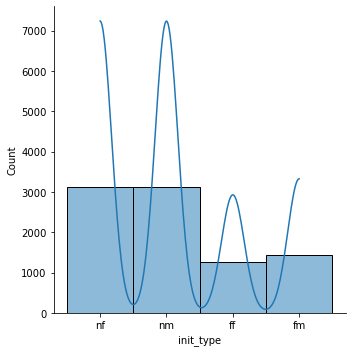

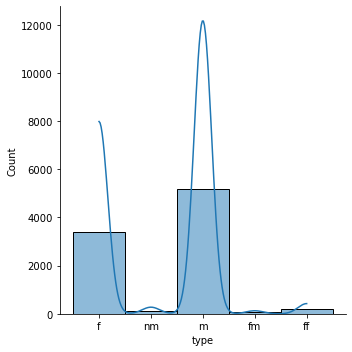

In [6]:
a = sns.displot(dff['init_type'],kde = True)
b = sns.displot(dff['type'],kde = True)

(array([ 117.,    0.,  180.,    0.,    0.,   54.,    0., 3393.,    0.,
        5175.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

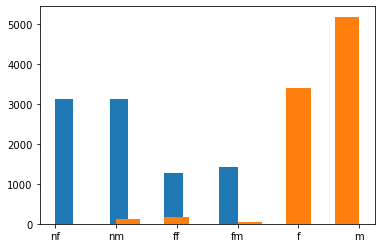

In [7]:
plt.hist(dff['init_type'])
plt.hist(dff['type'])

In [ ]:
plt.hist([str(i) for i in dff['init_type']])
plt.hist([str(i) for i in dff['type']])

In [3]:
df = []
for i in range(100):
    m = Model(16, i)
    m.step()
    df.append(m.giving_df)
dff=pd.concat(df)
# this has been saved in pickle as 'p'

In [7]:
dff['group wealth']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
       ...  
235    115.0
236    115.0
237    115.0
238    115.0
239    115.0
Name: group wealth, Length: 24000, dtype: float64

In [10]:
import seaborn as sns

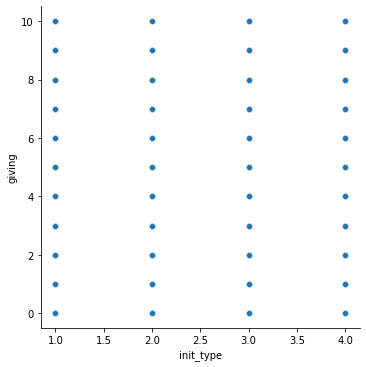

In [23]:
#1. rel--scatter plot
sns.relplot(data = dff, x='init_type',y='giving',kind='scatter')
#hue: group by type and assign different colors to them

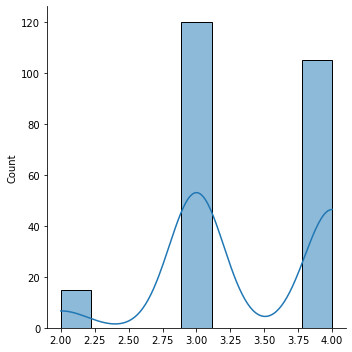

In [35]:
#3. dist
l = list(dff['init_type'][dff['round'] == 2])
avg1 = sns.displot(l, kde=True)#kde - kernel density 

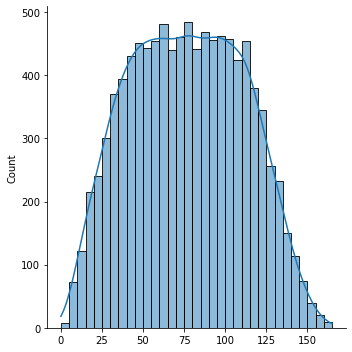

In [37]:
#3. dist
l = list(dff[dff.init_type == 3]['wealth'])
sns.displot(l,kde=True)#kde - kernel density 

In [19]:
g_out = []
g_h_in = []
g_l_in = []
empha = []

for r in dff.iterrows():
    if r[1][1] == r[1][3]:
        g_l_in.append(r[1][5])
    elif r[1][1]%2 == r[1][3]%2:
        g_h_in.append(r[1][5])
    else:
        g_out.append(r[1][5])
    empha.append(r[1][4])
 
    
wealth_by_init = []
for i in range(1,5):
    l = list(dff[dff['init_type'] == i]['wealth'])
    avg_wealth = sum(l) / len(l)
    wealth_by_init.append(avg_wealth)

(array([1457., 3367., 2662., 1916., 1502.,  877.,  250.,  237.,  223.,
         309.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

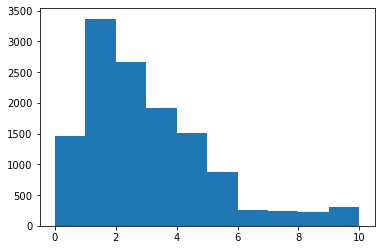

In [8]:
plt.hist(g_out) 

(array([344., 728., 317., 275., 260., 118.,  33.,  46.,  32.,  45.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

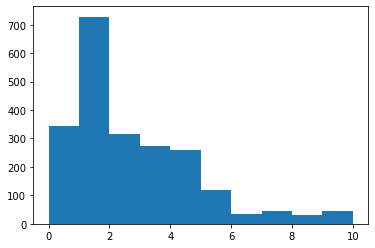

In [9]:
plt.hist(g_h_in)

(array([ 692., 2301., 2277., 1320., 1175.,  627.,  151.,  133.,  126.,
         200.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

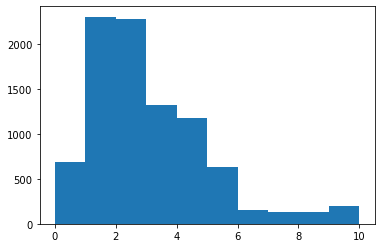

In [10]:
plt.hist(g_l_in)

(array([320., 636., 261., 245., 206., 110.,  28.,  46.,  25.,  43.]),
 array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
       dtype=object),
 <BarContainer object of 10 artists>)

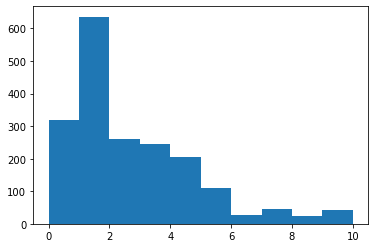

In [11]:
plt.hist(dff[dff['other type'] == 1]['giving'])

(array([ 1920.,     0.,     0.,   615.,     0.,     0., 10080.,     0.,
            0., 11385.]),
 array([1.0, 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.6999999999999997,
        4.0], dtype=object),
 <BarContainer object of 10 artists>)

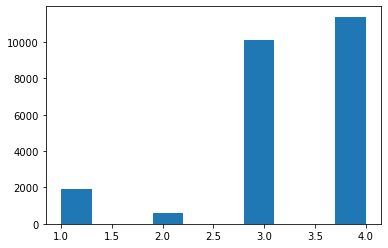

In [12]:
plt.hist(dff['init_type'])

(array([ 8235.,     0., 10650.,     0.,  1800.,     0.,  1260.,     0.,
         1965.,    90.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

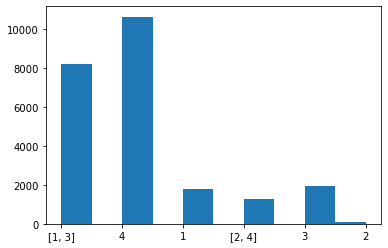

In [14]:
plt.hist([str(i) for i in dff['type']])

In [22]:
wealth_by_init

[89.0859375, 80.95772357723577, 76.41954365079366, 80.31655687307861]